### DoorDash Time until Delivery Prediction 
It is very important for DoorDash to get this metric right, as it has a big impact on consumer experience.
the total delivery duration seconds will be defined as the time between

Start: the time consumer submits the order (created_at) to  
End: when the order will be delivered to the consumer (actual_delivery_time)

this problem is a regression task  
let's start with data exploration as we always do  
Then, continue with investigating features for data preprocessing  
Lastly, we will examine the performance of different techniques. Let's begin!

#### EDA 

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# set random seed to have reproducible results
# sklearn uses numpy random seed
np.random.seed(42)

In [35]:
historical_data = pd.read_csv("./data/historical_data.csv")
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [36]:
#Check the column data types and non-null count through dataframe.info( ).
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

A few observations:
1. there exist a few id columns, which are generally not useful in prediction tasks.  
2. The dataset includes null values which we must deal with
3. there is no column in the dataset that represents our target value explicitly.  
    a. can calculate it by using the diff b/w created_at & actual_delivery_time. 

In [37]:
from datetime import datetime 
# convert to datetime type
historical_data["created_at"] = pd.to_datetime(historical_data['created_at'])
historical_data["actual_delivery_time"] = pd.to_datetime(historical_data['actual_delivery_time'])
#  perform aforementioned calculation
historical_data["actual_total_delivery_duration"] = (historical_data["actual_delivery_time"] - historical_data["created_at"]).dt.total_seconds()
# boom
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


A feature we can add to the dataframe is estimated non-preparation duration.  
We would add estimated store-to-consumer driving and estimated order place durations.  
Total order delivery duration would segment into two main operations: Preparation and non-preparation. 
This is the feature engineering part.

In [38]:
historical_data['estimated_non_prep_duration'] = historical_data["estimated_store_to_consumer_driving_duration"] + historical_data["estimated_order_place_duration"]
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0


We have total busy dashers and total onshift dashers as two columns.  
This columns could be informative about current availability.  
Calculate by dividing total_busy_dashers to total_onshift_dashers, some rows are >1....why

In [39]:
historical_data["busy_dashers_ratio"] = historical_data["total_busy_dashers"] / historical_data["total_onshift_dashers"]
historical_data[historical_data.busy_dashers_ratio > 1]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000
7,3.0,2015-02-12 03:03:35,2015-02-12 03:36:20,5477,NaN,1.0,4,4850,4,750,1800,7.0,8.0,7.0,446,626.0,1965.0,1072.0,1.142857
14,1.0,2015-02-12 03:36:46,2015-02-12 04:14:39,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,2273.0,1241.0,1.200000
18,1.0,2015-01-31 04:35:54,2015-01-31 05:47:30,2841,italian,1.0,2,3150,2,1425,1725,4.0,9.0,12.0,446,548.0,4296.0,994.0,2.250000
20,1.0,2015-01-31 23:45:12,2015-02-01 00:14:05,4139,mexican,1.0,5,1285,3,150,400,12.0,13.0,11.0,446,424.0,1733.0,870.0,1.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197411,1.0,2015-02-02 17:50:23,2015-02-02 18:12:57,2956,fast,4.0,2,1297,2,369,639,5.0,6.0,7.0,251,186.0,1354.0,437.0,1.200000
197412,1.0,2015-02-10 23:43:08,2015-02-11 00:47:24,2956,fast,4.0,1,674,1,345,345,10.0,11.0,12.0,251,706.0,3856.0,957.0,1.100000
197418,1.0,2015-01-30 20:50:23,2015-01-30 22:24:38,2956,fast,4.0,2,1528,2,639,729,26.0,29.0,34.0,251,791.0,5655.0,1042.0,1.115385
197422,1.0,2015-01-31 19:48:15,2015-01-31 20:27:39,2956,fast,4.0,7,2445,3,145,585,23.0,24.0,24.0,251,608.0,2364.0,859.0,1.043478


Another categorical feature is store_primary_category.  
This column includes some nulls and actually, we can fill it.  
We can use the most repeated primary category with the associated store to fill this store's null primary category column.

In [40]:
store_id_unique = historical_data["store_id"].unique().tolist()
store_id_and_category = {store_id: historical_data[historical_data.store_id == store_id].store_primary_category.mode() 
                         for store_id in store_id_unique}

In [41]:
def fill(store_id):
    """Return primary store category from the dictionary"""
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan

# fill null values
historical_data["nan_free_store_primary_category"] = historical_data.store_id.apply(fill)

In [42]:
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio,nan_free_store_primary_category
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242,american
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000,indian
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000,indian
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000,indian
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000,indian


done! However, we observe discrepancies between column we created and the original primary categories.  
For example, store 5477 is associated with Mexican food in original and with Indian in our new column.  
Let's check why it's happening.

In [43]:
store_id_and_category[5477]

0     indian
1    mexican
Name: store_primary_category, dtype: object

Our dictionary says for the given store id, Mexican and Indian are seen equally on the DataFrame. 
And, it chooses the first value as in the fill function to replace nan values.  
Let's confirm it from the original dataset.

In [44]:
historical_data[historical_data.store_id == 5477]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio,nan_free_store_primary_category
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000,indian
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000,indian
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000,indian
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000,indian
5,3.0,2015-01-28 20:30:38,2015-01-28 21:08:58,5477,NaN,1.0,3,5000,3,1500,1900,2.0,2.0,2.0,446,338.0,2300.0,784.0,1.000000,indian
6,3.0,2015-01-31 02:16:36,2015-01-31 02:43:00,5477,NaN,1.0,2,3900,2,1200,2700,10.0,9.0,9.0,446,638.0,1584.0,1084.0,0.900000,indian
7,3.0,2015-02-12 03:03:35,2015-02-12 03:36:20,5477,NaN,1.0,4,4850,4,750,1800,7.0,8.0,7.0,446,626.0,1965.0,1072.0,1.142857,indian
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,1586.0,735.0,0.750000,indian
9,3.0,2015-02-18 01:15:45,2015-02-18 02:08:57,5477,NaN,1.0,2,2100,2,700,1200,2.0,2.0,2.0,446,715.0,3192.0,1161.0,1.000000,indian
10,3.0,2015-02-02 19:22:53,2015-02-02 20:09:19,5477,NaN,4.0,4,4300,4,1200,1500,1.0,1.0,1.0,446,453.0,2786.0,899.0,1.000000,indian


Yes, we were right. Mexican and Indian both are given in one instance for store 5477.  
We can't use these categories with their original names.  
We will apply hot-encoding onto them.  
cuisine might cause changes in preparation duration, so let's not drop this column.  
We decided previously to apply hot-encoding on some of the other categorical variables too.  
Let's do it by using pandas.getdummies()

In [22]:
historical_data["market_id"].nunique()

6

In [23]:
historical_data["store_id"].nunique() 

6743

In [24]:
historical_data["order_protocol"].nunique()

7

In [45]:
# create dummies for order protocol
order_protocol_dummies = pd.get_dummies(historical_data.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [46]:
# create dummies for market_id
market_id_dummies = pd.get_dummies(historical_data.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [47]:
# create dummies for store primary category
store_primary_category_dummies = pd.get_dummies(historical_data.nan_free_store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')
store_primary_category_dummies.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,category_breakfast,category_british,category_bubble-tea,category_burger,category_burmese,category_cafe,category_cajun,category_caribbean,category_catering,category_cheese,category_chinese,category_chocolate,category_comfort-food,category_convenience-store,category_dessert,category_dim-sum,category_ethiopian,category_european,category_fast,category_filipino,category_french,category_gastropub,category_german,category_gluten-free,category_greek,category_hawaiian,category_indian,category_indonesian,category_irish,category_italian,category_japanese,category_korean,category_kosher,category_latin-american,category_lebanese,category_malaysian,category_mediterranean,category_mexican,category_middle-eastern,category_moroccan,category_nepalese,category_other,category_pakistani,category_pasta,category_persian,category_peruvian,category_pizza,category_russian,category_salad,category_sandwich,category_seafood,category_singaporean,category_smoothie,category_soup,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's drop columns that have been encoded  
We extract the total delivery duration from created and actual delivery time columns, so drop those too  

In [48]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, actual_total_delivery_duration
train_df = historical_data.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                                        "nan_free_store_primary_category", "order_protocol"])
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000


Finally, concatenate all created columns and the final version of our DataFrame.  
Convert all to float to use them with machine learning methods.

In [49]:
train_df = pd.concat([train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)
# cast type to float
train_df = train_df.astype("float32")
# let's peep at a few rows
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,category_breakfast,category_british,category_bubble-tea,category_burger,category_burmese,category_cafe,category_cajun,category_caribbean,category_catering,category_cheese,category_chinese,category_chocolate,category_comfort-food,category_convenience-store,category_dessert,category_dim-sum,category_ethiopian,category_european,category_fast,category_filipino,category_french,category_gastropub,category_german,category_gluten-free,category_greek,category_hawaiian,category_indian,category_indonesian,category_irish,category_italian,category_japanese,category_korean,category_kosher,category_latin-american,category_lebanese,category_malaysian,category_mediterranean,category_mexican,category_middle-eastern,category_moroccan,category_nepalese,category_other,category_pakistani,category_pasta,category_persian,category_peruvian,category_pizza,category_russian,category_salad,category_sandwich,category_seafood,category_singaporean,category_smoothie,category_soup,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,3779.0,1307.0,0.424242,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,4024.0,1136.0,2.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,1781.0,1136.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,3075.0,735.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,2390.0,1096.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's check our final dataset.

In [52]:
pd.set_option('display.max_columns', None)


In [53]:
train_df.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,category_breakfast,category_british,category_bubble-tea,category_burger,category_burmese,category_cafe,category_cajun,category_caribbean,category_catering,category_cheese,category_chinese,category_chocolate,category_comfort-food,category_convenience-store,category_dessert,category_dim-sum,category_ethiopian,category_european,category_fast,category_filipino,category_french,category_gastropub,category_german,category_gluten-free,category_greek,category_hawaiian,category_indian,category_indonesian,category_irish,category_italian,category_japanese,category_korean,category_kosher,category_latin-american,category_lebanese,category_malaysian,category_mediterranean,category_mexican,category_middle-eastern,category_moroccan,category_nepalese,category_other,category_pakistani,category_pasta,category_persian,category_peruvian,category_pizza,category_russian,category_salad,category_sandwich,category_seafood,category_singaporean,category_smoothie,category_soup,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,1.974210e+05,196902.000000,1.775900e+05,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.00000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.00000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.331543,2.670791,686.218506,1159.588623,44.808094,41.739746,58.050064,308.560181,545.358948,2.908258e+03,853.939209,NaN,0.277190,0.121827,0.269460,0.098031,0.224335,0.004022,0.000096,0.192663,0.278876,0.118003,0.241095,0.091172,0.073191,0.000588,0.000051,0.009431,0.000005,0.101429,0.000349,0.01360,0.013894,0.000010,0.001580,0.028036,0.000658,0.002700,0.057327,0.004331,0.01129,0.001935,0.001256,0.008403,0.000122,0.048139,0.000005,0.000162,0.001788,0.046002,0.005764,0.000699,0.000106,0.038247,0.001357,0.002923,0.000952,0.000329,0.000299,0.017171,0.007765,0.037690,0.000010,0.000268,0.036834,0.047724,0.009173,0.000263,0.002629,0.000582,0.000507,0.027939,0.087708,0.007501,0.000142,0.001585,0.020134,0.000699,0.003237,0.003277,0.001337,0.089227,0.000091,0.01

In [31]:
train_df["busy_dashers_ratio"].describe()

count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

It seems we have high max-min differences for some columns and infinity values.  
Need to replace all infinity values with nan since they are not useful in the prediction.

In [54]:
# check infinity values with using numpy isfinite() function
np.where(np.any(~np.isfinite(train_df),axis=0) == True)

(array([ 5,  6,  7,  9, 10, 11, 12]),)

In [55]:
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# drop all nans
train_df.dropna(inplace=True)
train_df.shape

(177070, 100)

In [57]:
# confirm there is not any remaining nans
# .sum().sum() twice over each dimension
train_df.isna().sum().sum()

0

### Remove Redundant and Collinear Features
100 columns is a lot, implying there might be redundant features.  
These features don't add any new knowledge to ML models.  
Another potential problem is collinearity. 
We start with the correlation matrix.

<AxesSubplot: >

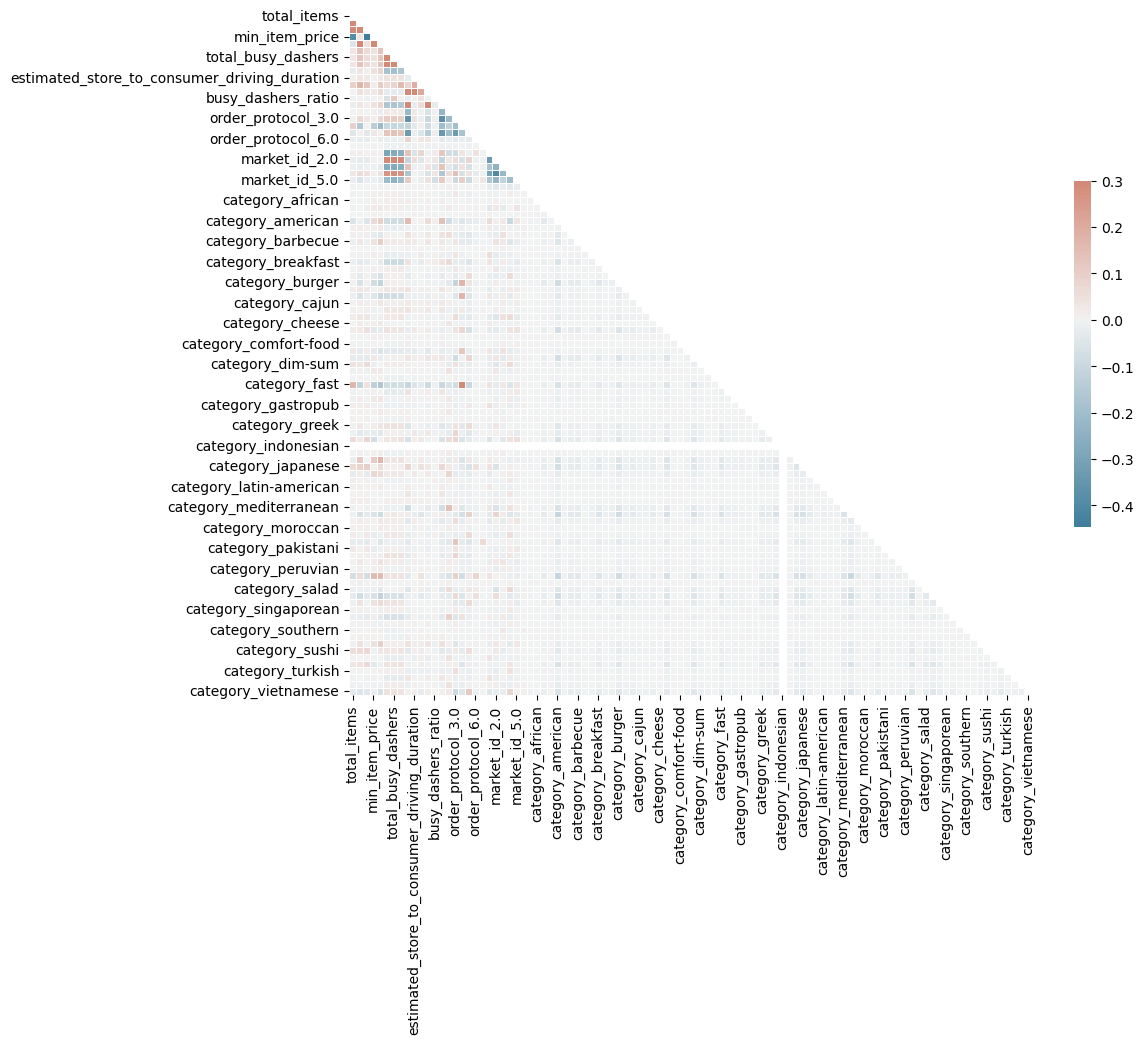

In [39]:
# it could take some time to run this cell since we are calculating correlation matrix in a dimesion of (100x100)
# to have a better visualization, we will take only one triangle 

# Generate a mask for the upper triangle
corr = train_df.corr()
# seaborn.pydata.org/examples/many_pairwise_correlations.html
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

It seems there is a problem with category_indonesian. Check with .describe( ).

In [40]:
train_df['category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

It has a zero std value. We can drop it. --> stats.stackexchange.com/questions/309612  
Let's see the top correlated features.

In [58]:
# highly correlated features are bad, so let's find them.
def get_redundant_pairs(df):
    """Get diagonal and lower triangular pairs of correlation matrix"""
    # empty set
    pairs_to_drop = set()
    # all cols
    cols = df.columns
    # loop through cols with an iterator ahead by 1
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            # save these current two iterators as tuple in the set
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    """Sort correlations in the descending order and return n highest results"""
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
order_protocol_4.0                            category_fast                  0.489946
num_distinct_items          

We have very highly correlated features.  
Some columns have information could be captured by other features, meaning redundancy
1. total_busy_dashers & total_onshift_dashers are represented by busy_dashers_ratio, so drop!
2. estimated_non_prep_duation (we created) is correlated with driving and order place duration, so let it go! 
3. market id values are also correlated with each other, so we won't concat them into the dataframe anymore.

Let's do it and check the correlations again

In [62]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df = historical_data.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                                        "nan_free_store_primary_category", "order_protocol"])
# don't concat market id
train_df = pd.concat([train_df, order_protocol_dummies, store_primary_category_dummies], axis=1)
# drop highly correlated features
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers",
                                  "category_indonesian", 
                                  "estimated_non_prep_duration"])
# align dtype over dataset
train_df = train_df.astype("float32")

In [63]:
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,category_breakfast,category_british,category_bubble-tea,category_burger,category_burmese,category_cafe,category_cajun,category_caribbean,category_catering,category_cheese,category_chinese,category_chocolate,category_comfort-food,category_convenience-store,category_dessert,category_dim-sum,category_ethiopian,category_european,category_fast,category_filipino,category_french,category_gastropub,category_german,category_gluten-free,category_greek,category_hawaiian,category_indian,category_irish,category_italian,category_japanese,category_korean,category_kosher,category_latin-american,category_lebanese,category_malaysian,category_mediterranean,category_mexican,category_middle-eastern,category_moroccan,category_nepalese,category_other,category_pakistani,category_pasta,category_persian,category_peruvian,category_pizza,category_russian,category_salad,category_sandwich,category_seafood,category_singaporean,category_smoothie,category_soup,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
train_df.shape

(177070, 90)

In [64]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
order_protocol_4.0              category_fast         0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duratio

It seems order protocols are also highly correlated with each other, so won't concatenate them.  
Let's repeat the process one more time.

In [65]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df = historical_data.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                                        "nan_free_store_primary_category", "order_protocol"])
# don't concat order_protocol_dummies
train_df = pd.concat([train_df, store_primary_category_dummies], axis=1)
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers",
                                  "category_indonesian", 
                                  "estimated_non_prep_duration"])
# align dtype over dataset
train_df = train_df.astype("float32")
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,category_breakfast,category_british,category_bubble-tea,category_burger,category_burmese,category_cafe,category_cajun,category_caribbean,category_catering,category_cheese,category_chinese,category_chocolate,category_comfort-food,category_convenience-store,category_dessert,category_dim-sum,category_ethiopian,category_european,category_fast,category_filipino,category_french,category_gastropub,category_german,category_gluten-free,category_greek,category_hawaiian,category_indian,category_irish,category_italian,category_japanese,category_korean,category_kosher,category_latin-american,category_lebanese,category_malaysian,category_mediterranean,category_mexican,category_middle-eastern,category_moroccan,category_nepalese,category_other,category_pakistani,category_pasta,category_persian,category_peruvian,category_pizza,category_russian,category_salad,category_sandwich,category_seafood,category_singaporean,category_smoothie,category_soup,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
subtotal                                      actual_total_delivery_duration    0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.17

Still, high correlations persists
total item number or distinct items could affect the duration of the preparation process, so we cannot drop 
We must feature engineer to infer the contribution of these columns.

In [67]:
# new features
train_df["percent_distinct_item_of_total"] = train_df["num_distinct_items"] / train_df["total_items"]
train_df["avg_price_per_item"] = train_df["subtotal"] / train_df["total_items"]
train_df.drop(columns=["num_distinct_items", "subtotal"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   percent_distinct_item_of_total    0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
max_item_price                                percent_distinct_item_of_total    0.178021
category_fast                                 avg_price_per_item                0.17

We will apply a similar trick for min and max item prices

In [68]:
train_df["price_range_of_items"] = train_df["max_item_price"] - train_df["min_item_price"]
train_df.drop(columns=["max_item_price", "min_item_price"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.445751
                                              price_range_of_items              0.333304
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
category_fast                                 avg_price_per_item                0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170988
category_italian                              avg_price_per_item                0.158193
total_outstanding_orders                      actual_total_delivery_duration    0.15

Below 0.5 correlation is acceptable, so we are done with feature engineering for now.  
We reduced our number of columns to 82.

### Multicollinearity Check

We will check Multicollinearity through Variance Inflation Factor (VIF).  
Eliminate all features that have VIF score above 20.
Important to drop only one feature at a time, since VIF updates upon new feature set

In [71]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [69]:
# create func which will update our progress
def compute_vif(features):
    """Compute VIF score using variance_inflation_factor() function"""
    # create df to store vals
    vif_data = pd.DataFrame()
    # store feature name
    vif_data["feature"] = features
    # perform calculation 
    vif_data["VIF"] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)


The running time of the next cell could be long, it is normal. It will calculate a VIF score for each column.

In [72]:
# apply VIF computation to all columns
features = train_df.drop(columns=["actual_total_delivery_duration"]).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000371
1,category_chocolate,1.000490
2,category_belgian,1.000749
3,category_russian,1.003226
4,category_african,1.003820
...,...,...
76,busy_dashers_ratio,6.369592
77,category_american,7.033601
78,estimated_store_to_consumer_driving_duration,7.210817
79,estimated_order_place_duration,13.472088


Multicollinearity issue exists despite all our efforts with feature engineering  
Next, we will drop the columns with the VIF score over the threshold.

In [73]:
# drop with highest vif score until all vif scores are under 20
multicollinearity = True

# Multicollinearity over 20 is unacceptable so let's remove features one at a time till not true
while multicollinearity:
    # last value in the column is highest
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print("We will remove", highest_vif_feature)
    # be gone!
    features.remove(highest_vif_feature)
    # let's run this one more time
    vif_data = compute_vif(features)
    # our exit condition
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True

# spit out our data and see current state
selected_features = vif_data['feature'].values.tolist()
vif_data

We will remove percent_distinct_item_of_total


,feature,VIF
0,category_alcohol-plus-food,1.000222
1,category_chocolate,1.000363
2,category_belgian,1.000451
3,category_russian,1.002016
4,category_gluten-free,1.002363
...,...,...
75,category_american,4.505927
76,avg_price_per_item,5.958953
77,busy_dashers_ratio,6.357883
78,estimated_store_to_consumer_driving_duration,7.192617


It was enough to just drop percent_distinct_item_of_total

### Feature Selection
We have a rich feature set.  
However, to reduce the noise in the model and decrease the training duration, we can use a subset of these features instead
Let's investigate the feature importances.  
Use RandomForestRegressor to get the importance of each feature in the prediction of the actual total delivery duration.

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# selected features are selected in multicollinearity check part
X = train_df[selected_features]
y = train_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

After fitting the model, let's sort all features based on their importance and visualize them.

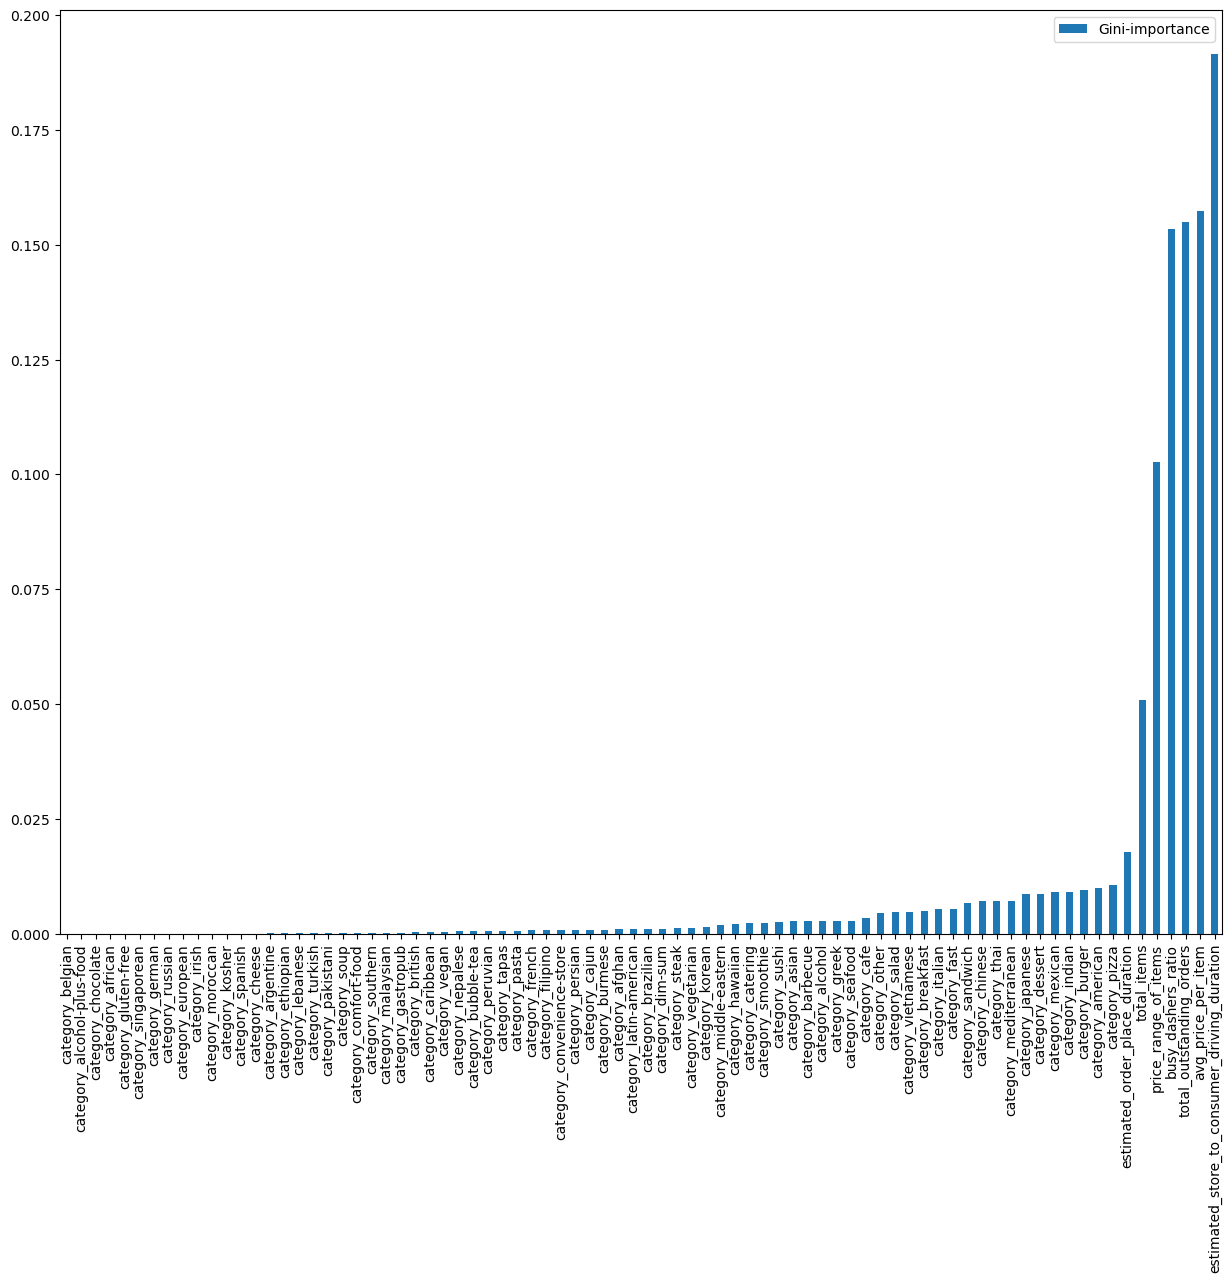

In [75]:
# store features names
feature_names = [f"feature {i}" for i in range((X.shape[1]))]
# create instance of the model
forest = RandomForestRegressor(random_state=42)
# train the model
forest.fit(X_train, y_train)
# dictionary to store with vals of importance
feats = {}
# tuple iterator using zip
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance #add the name/value pair 
# convert to pandas DF, sort, and then plot
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

Many of the features have a very marginal contribution to regression. Let's check the most important ones.

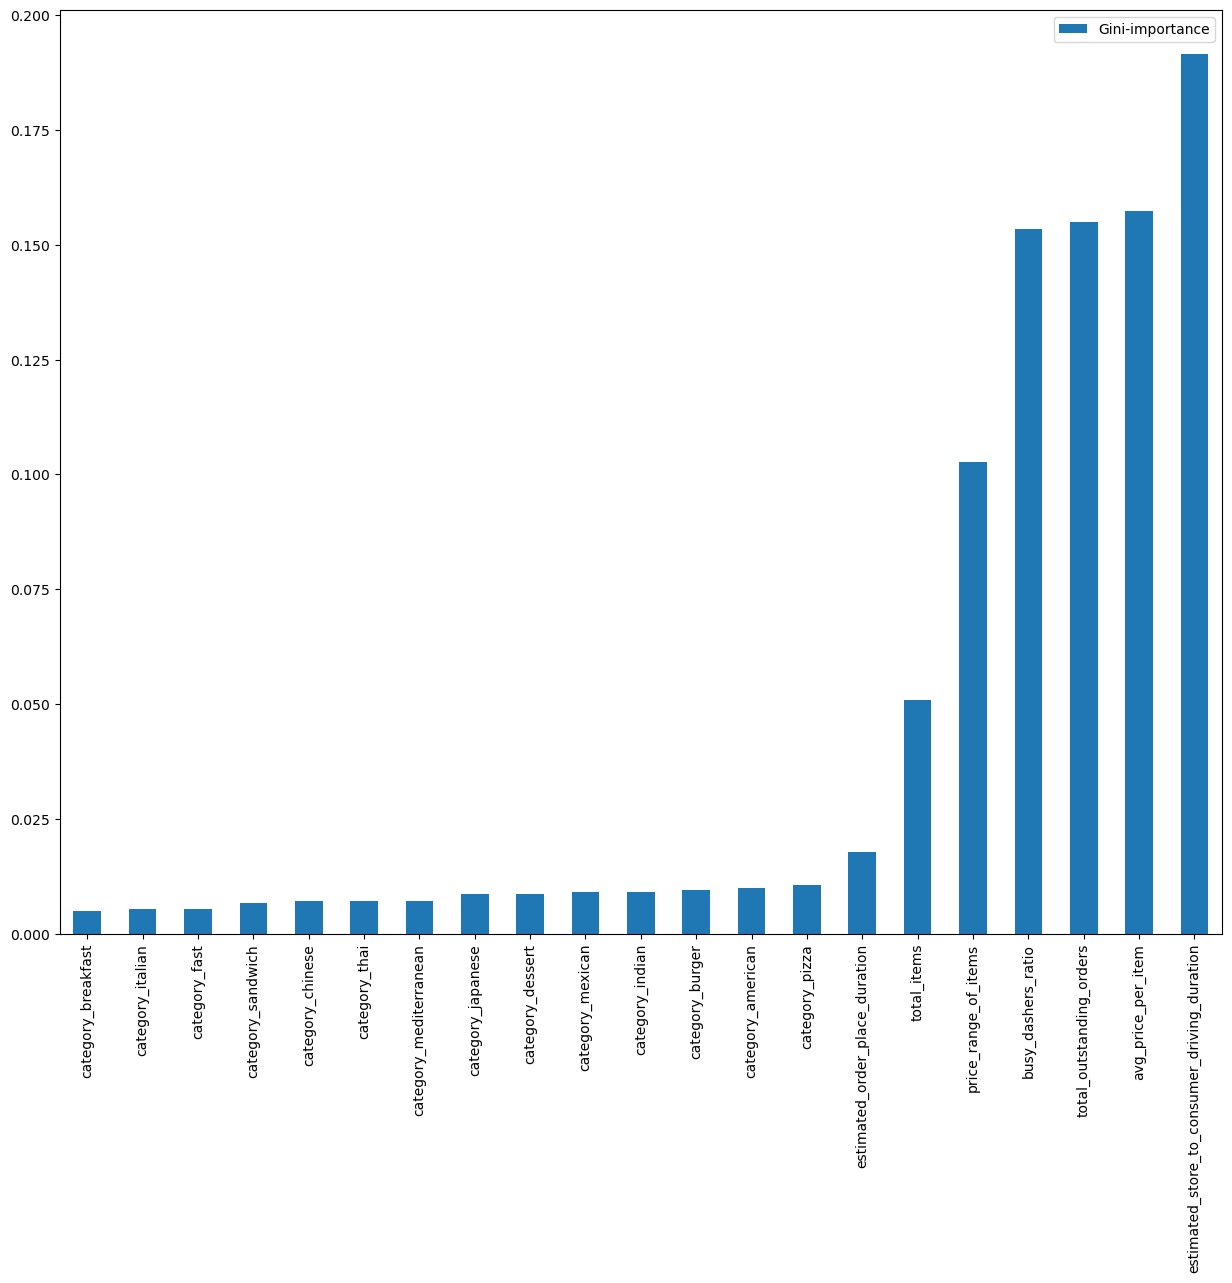

In [77]:
importances[importances["Gini-importance"] > 0.005].sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

As expected, estimated store-to-consumer driving duration is very important to overall delivery duration.  
Busy dashers ratio, total outstanding orders, and average price per item are also highly contributed features.  
We can choose our final features subset using these importances.

In [78]:
# we can obtain the column names next
importances.sort_values(by='Gini-importance')[-35:].index.tolist()

['category_middle-eastern',
 'category_hawaiian',
 'category_catering',
 'category_smoothie',
 'category_sushi',
 'category_asian',
 'category_barbecue',
 'category_alcohol',
 'category_greek',
 'category_seafood',
 'category_cafe',
 'category_other',
 'category_salad',
 'category_vietnamese',
 'category_breakfast',
 'category_italian',
 'category_fast',
 'category_sandwich',
 'category_chinese',
 'category_thai',
 'category_mediterranean',
 'category_japanese',
 'category_dessert',
 'category_mexican',
 'category_indian',
 'category_burger',
 'category_american',
 'category_pizza',
 'estimated_order_place_duration',
 'total_items',
 'price_range_of_items',
 'busy_dashers_ratio',
 'total_outstanding_orders',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

Another method to decrease feature dimension is PCA (Principal Component Analysis).  
It maps all features to another plane and obtains the most representative interpretations to explain all variances in the DataFrame.



/var/folders/ph/hf46cbxx0bj_5t8gb0d0zsv00000gp/T/ipykernel_70500/861724429.py:11: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0,81,1)


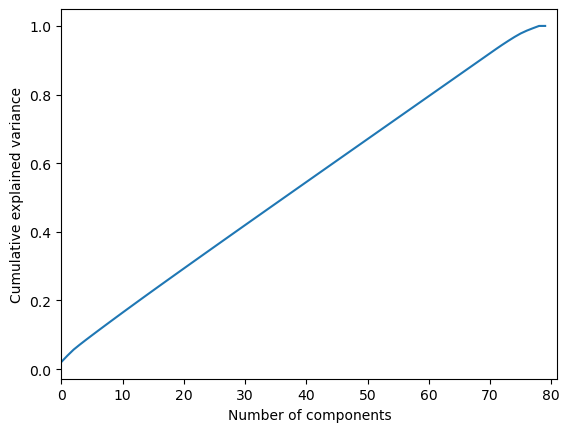

In [79]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_Train=X_train.values
X_Train=np.asarray(X_Train)

# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

PCA shows that we need to use at least 60 representative features to explain 80% of the dataset, which makes the PCA transformation useless since we already have 80 and could select the most important ones based on feature importance.  
If PCA would tell us it can explain the majority of variance with around 10 features (high reduction) we would continue with it.

### Apply Scaler
We are done with features. We move to modelling part.  
In data exploration part, we observed great range across cols in the dataframe.  
This is good motivation to use scaler for the sake of regression performance.   
We implement a generic function that could use any sklearn scaler.  
Let's test MinMaxScaler and StandardScaler and observe performance difference, if any.

In [81]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale(scaler, X, y):
    """Apply the selected scaler to features and target variables"""
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler

In [82]:
# example to show how to use it
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

In [83]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42)

### Inverse Transform for Metric Comparison

A few notes:
1. Since we applied a scaler to training data, the predictions on test data will also be scaled.  
2. So to get our target back, we need to apply the inverse transformation.   
3. Use Root Mean Squared Error to measure error (or Mean Squared Error or Mean Absolute Error)   
    a. We chose RMSE based on the sensitivity for high error terms  

The assumption is that consumer patience from delivery delay could decrease exponentially with time.  
A detailed comparison of MAE, MSE, and, RMSE is here: towardsdatascience.com/comparing-robustness-of-mae-mse-and-rmse-6d69da870828

In [84]:
from sklearn.metrics import mean_squared_error
# apply inverse transform
def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    """Convert the scaled error to actual error"""
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    # return RMSE with squared False     
    rmse_error = mean_squared_error(y_test, y_predict[:,0], squared=False)
    print("Error = "'{}'.format(rmse_error)+" in " + model_name)
    
    return rmse_error, y_predict

### Classical Machine Learning
Since we have no prior knowledge about which regressor has the best performance with our problem, we will try several of them.  
we implement a generic regression function below

In [91]:
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    """Apply selected regression model to data and measure error"""
    # train
    model.fit(X_train,y_train)
    # perform predictions
    y_predict=model.predict(X_train)
    # calculate train error
    train_error = mean_squared_error(y_train, y_predict, squared=False)
    # perform predictions
    y_predict=model.predict(X_test)
    # calculate test error
    test_error = mean_squared_error(y_test, y_predict, squared=False)
    # return error vals
    if verbose:
        print("Train error = "'{}'.format(train_error)+" in " + model_name)
        print("Test error = "'{}'.format(test_error)+" in " + model_name)
    trained_model = model
    
    return trained_model, y_predict, train_error, test_error

We will experiment with different regression models, feature sets, and scalers.  
We will store the error rate for each model in pred_dict.  
Then, we will plot and comment performance. It is necessary to see what works best for higher performance.

In [92]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": [],
}
regression_models = {
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(),
}
feature_sets = {
    "full dataset": X.columns.to_list(),
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
    "selected_features_20": importances.sort_values(by='Gini-importance')[-20:].index.tolist(),
    "selected_features_10": importances.sort_values(by='Gini-importance')[-10:].index.tolist(), 
}
scalers = {
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
    "NotScale": None,
}
# different features
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    # try diff scalers
    for scaler_name in scalers.keys():
        # print out whats included in model
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        # diff models
        for model_name in regression_models.keys():
            # one case where we don't scale
            if scaler_name == "NotScale":
                X = train_df[feature_set]
                y = train_df["actual_total_delivery_duration"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=True)
            else:  
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                    X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)

            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are full dataset

Error = 2053.69873046875 in Ridge
Error = 2057.2476687088733 in DecisionTree
Error = 2048.9868551249415 in RandomForest
Error = 2036.2498779296875 in XGBoost
Error = 2033.4355809987908 in LGBM
Error = 2038.3131103515625 in MLP
-----scaled with MinMax scaler-------- included columns are full dataset

Error = 2053.962890625 in Ridge
Error = 2057.2476685732177 in DecisionTree
Error = 2047.3815922966082 in RandomForest
Error = 2036.561279296875 in XGBoost
Error = 2034.4499976619875 in LGBM
Error = 2084.372314453125 in MLP
-----scaled with NotScale-------- included columns are full dataset



/Users/bryancoronelnew/opt/anaconda3/envs/stratascratch/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.42534e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1071.4971923828125 in Ridge
Test error = 2053.692626953125 in Ridge
Train error = 1067.7815291116704 in DecisionTree
Test error = 2057.2476684096064 in DecisionTree
Train error = 397.9691409552383 in RandomForest
Test error = 2049.080394483661 in RandomForest


/Users/bryancoronelnew/opt/anaconda3/envs/stratascratch/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Train error = 968.2471313476562 in XGBoost
Test error = 2036.43212890625 in XGBoost
Train error = 1017.5549840201221 in LGBM
Test error = 2034.461097275308 in LGBM


/Users/bryancoronelnew/opt/anaconda3/envs/stratascratch/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1054.1629638671875 in MLP
Test error = 2047.1083984375 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2054.00439453125 in Ridge
Error = 2056.5292024696128 in DecisionTree
Error = 2048.3881980972455 in RandomForest
Error = 2035.453369140625 in XGBoost
Error = 2034.6538984910121 in LGBM
Error = 2036.3084716796875 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_40

Error = 2054.27734375 in Ridge
Error = 2056.5292023632996 in DecisionTree
Error = 2048.7120836053523 in RandomForest
Error = 2036.3470458984375 in XGBoost
Error = 2035.196536738781 in LGBM
Error = 2117.206298828125 in MLP
-----scaled with NotScale-------- included columns are selected_features_40

Train error = 1072.35498046875 in Ridge
Test error = 2054.00439453125 in Ridge


/Users/bryancoronelnew/opt/anaconda3/envs/stratascratch/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.55922e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1067.785563647774 in DecisionTree
Test error = 2056.529202224364 in DecisionTree
Train error = 397.30651392503745 in RandomForest
Test error = 2047.8429743595345 in RandomForest


/Users/bryancoronelnew/opt/anaconda3/envs/stratascratch/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Train error = 965.6858520507812 in XGBoost
Test error = 2035.7642822265625 in XGBoost
Train error = 1017.1430421117441 in LGBM
Test error = 2034.8058530174258 in LGBM


/Users/bryancoronelnew/opt/anaconda3/envs/stratascratch/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1061.02734375 in MLP
Test error = 2049.715576171875 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_20

Error = 2055.36572265625 in Ridge
Error = 2054.610311207463 in DecisionTree
Error = 2048.425891793036 in RandomForest
Error = 2037.6336669921875 in XGBoost
Error = 2036.0233846729805 in LGBM
Error = 2037.2978515625 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_20

Error = 2055.653076171875 in Ridge
Error = 2054.6103112689557 in DecisionTree
Error = 2049.3201291974083 in RandomForest
Error = 2037.1251220703125 in XGBoost
Error = 2035.581516471472 in LGBM
Error = 2069.70654296875 in MLP
-----scaled with NotScale-------- included columns are selected_features_20

Train error = 1074.506591796875 in Ridge
Test error = 2055.36572265625 in Ridge


/Users/bryancoronelnew/opt/anaconda3/envs/stratascratch/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.43858e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1069.1350906055598 in DecisionTree
Test error = 2054.610311170708 in DecisionTree
Train error = 399.09270509019416 in RandomForest
Test error = 2048.5916393406264 in RandomForest


/Users/bryancoronelnew/opt/anaconda3/envs/stratascratch/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Train error = 966.1651000976562 in XGBoost
Test error = 2036.249267578125 in XGBoost
Train error = 1018.9600610110249 in LGBM
Test error = 2035.9494403356318 in LGBM


/Users/bryancoronelnew/opt/anaconda3/envs/stratascratch/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1058.37646484375 in MLP
Test error = 2048.8515625 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_10

Error = 2056.568359375 in Ridge
Error = 2054.5971761770547 in DecisionTree
Error = 2052.254519677322 in RandomForest
Error = 2040.27001953125 in XGBoost
Error = 2038.1313604554389 in LGBM
Error = 2040.504150390625 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_10

Error = 2056.88232421875 in Ridge
Error = 2054.5971762373274 in DecisionTree
Error = 2051.2120031094437 in RandomForest
Error = 2039.672119140625 in XGBoost
Error = 2037.6564489201091 in LGBM
Error = 2069.312255859375 in MLP
-----scaled with NotScale-------- included columns are selected_features_10

Train error = 1076.7279052734375 in Ridge
Test error = 2056.568359375 in Ridge
Train error = 1069.2324011708552 in DecisionTree
Test error = 2054.597176140608 in DecisionTree
Train error = 400.39923687396544 in RandomForest
Test error = 205

/Users/bryancoronelnew/opt/anaconda3/envs/stratascratch/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Train error = 976.43798828125 in XGBoost
Test error = 2039.2135009765625 in XGBoost
Train error = 1022.939378192528 in LGBM
Test error = 2038.4873761329577 in LGBM
Train error = 1060.236083984375 in MLP
Test error = 2050.853515625 in MLP


In [ ]:
pred_df = pd.DataFrame(pred_dict)
pred_df

In [ ]:
pred_df.plot(kind='bar', figsize=(12,8))

A few observations:

1. High errors persist through all models
2. the models inform us to not scale affects the performance.  
    a. We could pick one of the scalers and continue since it doesn't affect the performance much.  
3. decrease in training feature size first slightly improves the performance and then marginally made it worse. 
    a. We choose to use 40 as a final decision.  

### Change in Approach 
What else could we do more to improve it? Could it be our dataset is not a good representative for estimating the total delivery duration?  
One idea could be predicting preparation time and using the given estimated store-to-consumer driving ratio and order place, to sum up, and find the total delivery duration. Let's try it.

In [ ]:
# change the problem a bit
train_df["prep_time"] = train_df["actual_total_delivery_duration"] - train_df["estimated_store_to_consumer_driving_duration"] - train_df["estimated_order_place_duration"]

# not scaling affects the performance, so continue to scale but it doesn't matter much which scaler we used
scalers = {
    "Standard scaler": StandardScaler(),
}
feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            #drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

<b> LGBM consistently performs best. </b> Choose best perform model and extract the predictions for preparation duration

In [ ]:
# not scaling affects the performance, so continue to scale but it doesn't matter much which scaler we used
scalers = {
    "Standard scaler": StandardScaler(),
}
feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}
regression_models = {
    "LGBM": LGBMRegressor(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            #drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

In [ ]:
# choose best perform model and extract the predictions for preparation duration
pred_values_dict = {
    "actual_total_delivery_duration": train_df["actual_total_delivery_duration"][test_indices].values.tolist(), 
    "prep_duration_prediction": y_predict[:,0].tolist(),
    "estimated_store_to_consumer_driving_duration": train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration": train_df["estimated_order_place_duration"][test_indices].values.tolist(),             
}
# convert it to dataframe from dict
values_df = pd.DataFrame.from_dict(pred_values_dict)
values_df

We obtained the predictions for the preparation duration of each order.  
Now, we can sum it up with non-preparation activities such as order placing and driving.

In [ ]:
values_df["sum_total_delivery_duration"] = values_df["prep_duration_prediction"] + values_df["estimated_store_to_consumer_driving_duration"] + values_df["estimated_order_place_duration"]
values_df

Let's check if the error rate is better after changing the approach.

In [ ]:
mean_squared_error(values_df["actual_total_delivery_duration"], values_df["sum_total_delivery_duration"], squared=False)

It is not better and very close to the previous error.  
<b>What if we use another regression to obtain the actual total delivery duration using preparation duration prediction, estimated store-to-consumer driving duration, and order place duration? Recall, prep_duration is a prediction (from LGBM regressor)</b> Would it be a solution?

In [ ]:
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
regression_models = {
    "LinearReg" : linear_model.LinearRegression(),
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(),
}
for model_name in regression_models.keys():
    _, y_predict, _, _= make_regression(
        X_train, y_train, X_test, y_test,regression_models[model_name], model_name, verbose=False)
    print("RMSE of:",model_name, mean_squared_error(y_test,y_predict, squared=False))

Yes, this approach has better performance! We can choose this one as our official solution.

### Deep Learning
Could ANN have a better performance for the given problem?  
MLP performance was not better than tree-based regression in the preparation duration prediction part, so we doubt it.  
However, MLP has a good performance on the prediction of actual total delivery using preparation, driving, and order place duration.  
Let's give it a try for this one!

In [ ]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.random.set_seed(42)

# Neural network
def create_model(feature_set_size):
    
    # define the model
    model = Sequential()
    model.add(Dense(16, input_dim=feature_set_size, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    # compile the model
    model.compile(optimizer='sgd', loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [ ]:
print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
print("")
model_name = "ANN"   
scaler_name = "Standard scaler"
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42)
print("feature_set_size:",X_train_scaled.shape[1])
model = create_model(feature_set_size=X_train_scaled.shape[1])
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)
y_pred = model.predict(X_test_scaled)
rmse_error = rmse_with_inv_transform(y_scaler, y_test, y_pred, model_name)
pred_dict["regression_model"].append(model_name)
pred_dict["feature_set"].append(feature_set_name)
pred_dict["scaler_name"].append(scaler_name)
pred_dict["RMSE"].append(rmse_error)

In [ ]:
plt.plot(history.history['loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.show()

We achieved the same performance with the MLP method of sklearn.  
It could be possible to improve the performance a bit more with hyperparameter tuning in ANN, however, it requires considerable time and effort.  
Would it be a better approach when we already have a good performance Linear Regression model which is very simple and fast? It is a design choice.  
Use LGBM to predict prep_time (actual_total_delivery_duration - estimated_store_to_consumer_driving_duration - train_df) and then linear regression to actual_total_delivery_duration.  
We leave our official solution as <b> LGBM + Linear Regression on top </b>.